In [ ]:
# REFERENCE FROM https://www.kaggle.com/code/shreyachaturvedi1231/pretrained1, for reference only

In [1]:
import numpy as np
import pandas as pd
import os
import glob
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


In [6]:
from tensorflow.keras.applications import ResNet50

In [2]:
BASE_DIR = "./dataset/"
CSV_PATH = os.path.join(BASE_DIR, "Data_Entry_2017.csv")

# Gather all image files across the 12 folders
IMAGE_DIR = os.path.join(BASE_DIR, "images")
IMAGE_FILES = {os.path.basename(f): f for f in glob.glob(os.path.join(IMAGE_DIR, "*.png"))}

print(f"Total images found: {len(IMAGE_FILES)}")

Total images found: 112120


In [3]:
df = pd.read_csv(CSV_PATH)
df = df[['Image Index', 'Finding Labels']]
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|'))

relevant_labels = ['Pneumonia', 'Cardiomegaly', 'Edema', 'Emphysema', 'Effusion', 'Infiltration', 'Atelectasis']
df_filtered = df[df['Finding Labels'].apply(lambda x: any(label in relevant_labels for label in x))]

def assign_label(labels):
    if 'Pneumonia' in labels:
        return 0
    elif 'Cardiomegaly' in labels:
        return 1
    elif 'Edema' in labels:
        return 2
    elif 'Emphysema' in labels:
        return 3
    elif 'Effusion' in labels:
        return 4
    elif 'Infiltration' in labels:
        return 5
    elif 'Atelectasis' in labels:
        return 6
    else:
        return 7

df_filtered = df_filtered.copy()
df_filtered['Label'] = df_filtered['Finding Labels'].apply(assign_label)
df_filtered['path'] = df_filtered['Image Index'].map(IMAGE_FILES.get)
df_filtered = df_filtered[df_filtered['path'].notnull()]

print("Class counts:\n", df_filtered['Label'].value_counts())
df_filtered.head()

Class counts:
 Label
5    14234
4    11198
6     5707
1     2735
3     2424
2     1845
0     1431
Name: count, dtype: int64


,Image Index,Finding Labels,Label,path
0,00000001_000.png,[Cardiomegaly],1,./dataset/images\00000001_000.png
1,00000001_001.png,"[Cardiomegaly, Emphysema]",1,./dataset/images\00000001_001.png
2,00000001_002.png,"[Cardiomegaly, Effusion]",1,./dataset/images\00000001_002.png
7,00000003_003.png,"[Hernia, Infiltration]",5,./dataset/images\00000003_003.png
19,00000005_006.png,[Infiltration],5,./dataset/images\00000005_006.png


In [4]:
# Convert labels to string for categorical mode
df_filtered['Label'] = df_filtered['Label'].astype(str)

train_df, val_df = train_test_split(df_filtered, test_size=0.2, random_state=42)

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col='path',
    y_col='Label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col='path',
    y_col='Label',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)


Found 31659 validated image filenames belonging to 7 classes.
Found 7915 validated image filenames belonging to 7 classes.


In [10]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(7, activation='softmax')(x)  # Update the number of neurons to 7

model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False  # Freeze base model

model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_4[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [11]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10
)

Epoch 1/10
990/990 [==============================] - 1298s 1s/step - loss: 1.6484 - accuracy: 0.3568 - val_loss: 1.6201 - val_accuracy: 0.3407
Epoch 2/10
990/990 [==============================] - 902s 910ms/step - loss: 1.5917 - accuracy: 0.3784 - val_loss: 1.5624 - val_accuracy: 0.4013
Epoch 3/10
990/990 [==============================] - 910s 918ms/step - loss: 1.5872 - accuracy: 0.3834 - val_loss: 1.5673 - val_accuracy: 0.3879
Epoch 4/10
990/990 [==============================] - 895s 903ms/step - loss: 1.5767 - accuracy: 0.3805 - val_loss: 1.5688 - val_accuracy: 0.4042
Epoch 5/10
990/990 [==============================] - 906s 915ms/step - loss: 1.5716 - accuracy: 0.3896 - val_loss: 1.5510 - val_accuracy: 0.4005
Epoch 6/10
990/990 [==============================] - 961s 970ms/step - loss: 1.5687 - accuracy: 0.3904 - val_loss: 1.5584 - val_accuracy: 0.4019
Epoch 7/10
990/990 [==============================] - 903s 912ms/step - loss: 1.5690 - accuracy: 0.3858 - val_loss: 1.5584 - v

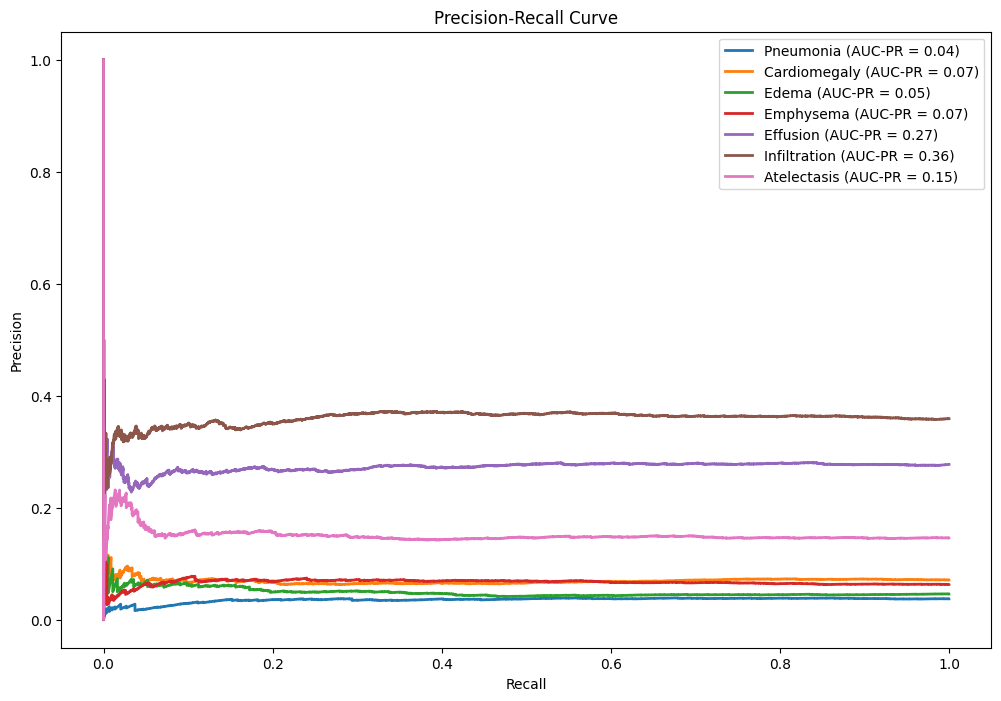

In [14]:
from sklearn.preprocessing import label_binarize

# Binarize the true labels
y_true = label_binarize(val_df['Label'].astype(int), classes=range(len(relevant_labels)))

# Compute Precision-Recall and AUC-PR for each class
precision = dict()
recall = dict()
auc_pr = dict()
for i in range(len(relevant_labels)):
    precision[i], recall[i], _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    auc_pr[i] = auc(recall[i], precision[i])

# Plot Precision-Recall curve for each class
plt.figure(figsize=(12, 8))
for i in range(len(relevant_labels)):
    plt.plot(recall[i], precision[i], lw=2, label=f'{relevant_labels[i]} (AUC-PR = {auc_pr[i]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.show()

In [15]:
model.save('thoracic_classifierV2.h5')  # Saves as HDF5 format
model.save('thoracic_classifierV2.keras')  # Saves as Keras format

## Testing the Model

1/1 [==============================] - 0s 59ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.4482791].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].



Image 1 probabilities:
Pneumonia: 3.52%
Cardiomegaly: 9.56%
Edema: 4.99%
Emphysema: 6.81%
Effusion: 29.67%
Infiltration: 33.87%
Atelectasis: 11.58%

Image 2 probabilities:
Pneumonia: 1.84%
Cardiomegaly: 2.59%
Edema: 0.31%
Emphysema: 5.50%
Effusion: 10.14%
Infiltration: 62.42%
Atelectasis: 17.21%

Image 3 probabilities:
Pneumonia: 2.72%
Cardiomegaly: 6.14%
Edema: 3.75%
Emphysema: 6.70%
Effusion: 24.61%
Infiltration: 38.10%
Atelectasis: 17.98%

Image 4 probabilities:
Pneumonia: 3.04%
Cardiomegaly: 5.55%
Edema: 10.22%
Emphysema: 3.22%
Effusion: 36.69%
Infiltration: 29.93%
Atelectasis: 11.35%


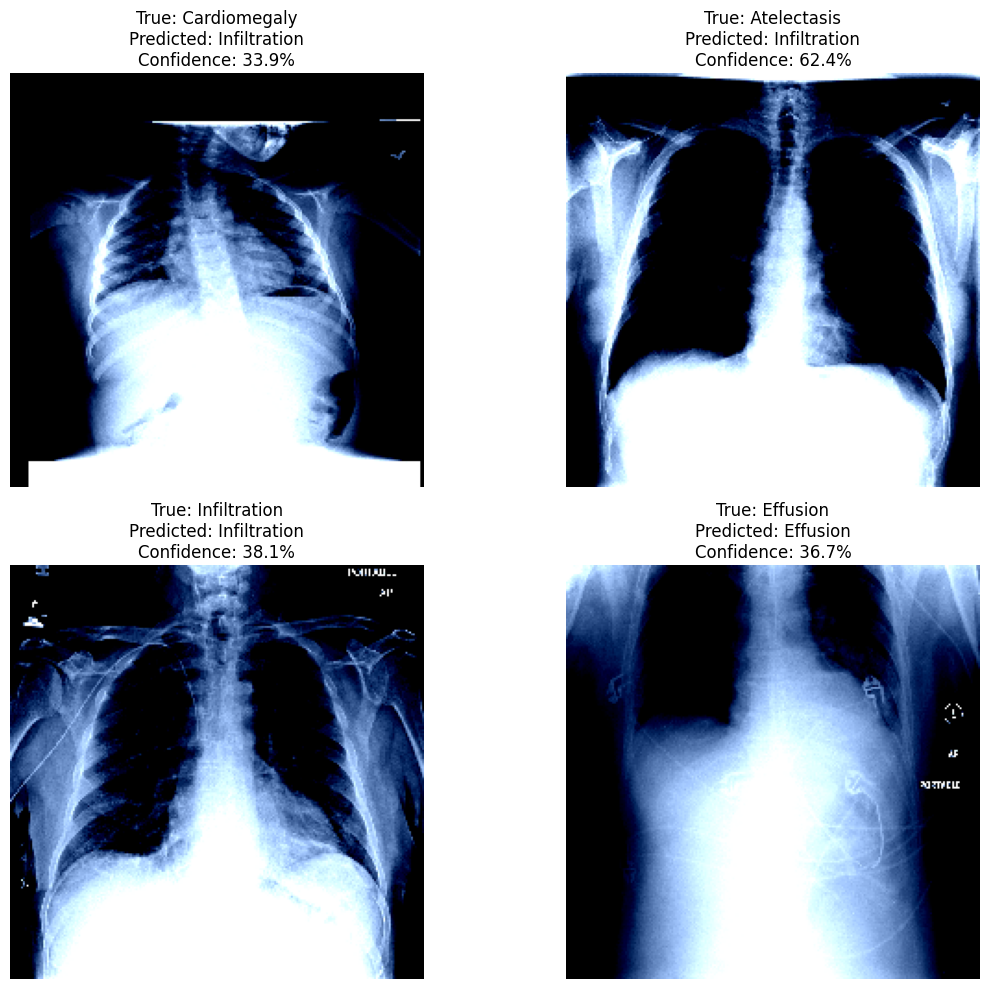

In [18]:
# Get a batch of images and labels from the validation generator
batch_images, batch_labels = next(train_gen)

# Make predictions on the batch
batch_preds = model.predict(batch_images)

# Define disease names mapping (based on your label assignments)
disease_names = ["Pneumonia", "Cardiomegaly", "Edema", 
                "Emphysema", "Effusion", "Infiltration", "Atelectasis"]

# Create a figure with 2x2 grid to display 4 random images
plt.figure(figsize=(12, 10))

# Display 4 random images from the batch
for i in range(4):
    # Choose a random image from the batch
    idx = np.random.randint(len(batch_images))
    img = batch_images[idx]
    
    # Get true and predicted labels
    true_label_idx = np.argmax(batch_labels[idx])
    pred_label_idx = np.argmax(batch_preds[idx])
    
    # Get disease names
    true_disease = disease_names[true_label_idx]
    pred_disease = disease_names[pred_label_idx]
    
    # Calculate confidence percentage
    confidence = batch_preds[idx][pred_label_idx] * 100
    
    # Plot the image in a subplot
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(f"True: {true_disease}\nPredicted: {pred_disease}\nConfidence: {confidence:.1f}%")
    plt.axis('off')
    
    # Print detailed probabilities for this image
    print(f"\nImage {i+1} probabilities:")
    for j, disease in enumerate(disease_names):
        prob = batch_preds[idx][j] * 100
        print(f"{disease}: {prob:.2f}%")

plt.tight_layout()
plt.show()